In [21]:
import numpy as np
from TDD.TDD import Index,Ini_TDD,Slicing3,cont,get_identity_tdd,get_norm,single_qubit_state_2_TDD
from TDD.TDD import diag_matrix_2_TDD,diag_matrix_2_TDD2,ccx_2_TDD,Single_qubit_gate_2TDD,cnot_2_TDD,Two_qubit_gate_2TDD
from TDD.TDD import measurement_2_TDD,condition_2_TDD
from TDD.TDD_show import TDD_show,TDD_show2
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
import time
import datetime
import copy
import pandas as pd
from func_timeout import func_set_timeout
import func_timeout
import networkx as nx
from networkx.algorithms.approximation.treewidth import treewidth_min_degree,treewidth_min_fill_in

In [22]:
def is_diagonal(U):
    i, j = np.nonzero(U)
    return np.all(i == j)

def get_classical_control_gate_num(cir):
    #classical bits are named c0,c1,...
    classical_control=dict()
    
    for k in range(len(cir._clbits)):
        c_idx='c'+str(k)
        classical_control[c_idx]=0

    gates=cir.data
    for k in range(len(gates)):
        if gates[k][0].condition:
            q_idx_con = gates[k][0].condition[0].name
            if len(q_idx_con)>=2:
                classical_control[q_idx_con]+=1
            else:
                bits = [int(k1) for k1 in list(bin(gates[k][0].condition[1])[2:])]
                num=1
                for k1 in range(len(bits)-1,-1,-1):
                    if bits[k1]==1:
                        q_idx_con = gates[k][0].condition[0].name+str(gates[k][0].condition[0].size-num)
                        classical_control[q_idx_con]+=1
                    num+=1
        else:
            continue
    return classical_control

def add_hyper_index(var_list,hyper_index):
    for var in var_list:
        if not var in hyper_index:
            hyper_index[var]=0
            
def add_index_2_node(var_list,node,index_2_node):
    for var in var_list:
        if not var in index_2_node:
            index_2_node[var]=set([node])
        else:
            index_2_node[var].add(node)

def add_index_set(var_list,index_set):
    for var in var_list:
        index_set.add(var)

In [23]:
#do not use hyper edge for noisy gate
def get_tensor_index(cir):
    """return a dict that link every quantum gate to the corresponding index"""
    node_2_index=dict()
    index_2_node=dict()
    index_set = set()

    qubits_index = dict()
    hyper_index=dict()
    measure_position=dict()
    
    classical_control = get_classical_control_gate_num(cir)
    
    for k in range(len(cir._clbits)):
        c_idx=cir._clbits[k].register.name+str(cir._clbits[k].index)
        qubits_index[c_idx]=0
        measure_position[c_idx]=0
    for k in range(len(cir._qubits)):
        q_idx=cir._qubits[k].register.name+str(cir._qubits[k].index)
        qubits_index[q_idx]=0

    
    gates=cir.data
    for k in range(len(gates)):
        if gates[k][0].name == "barrier":
            continue
        if gates[k][0].name == "measure":
            if len(gates[k][2][0].register.name)>=2:
                q_idx_con = gates[k][2][0].register.name
            else:
                q_idx_con = gates[k][2][0].register.name+str(gates[k][2][0].index)
            q_idx_tar = gates[k][1][0].register.name+str(gates[k][1][0].index) 
            var_tar_in=q_idx_tar+str(0)+str(qubits_index[q_idx_tar])         
            add_hyper_index([var_tar_in],hyper_index)                
            gate_index = [Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_in,hyper_index[var_tar_in]+1)]
            hyper_index[var_tar_in]+=2
            measure_position[q_idx_con]=var_tar_in
            if classical_control[q_idx_con]==0:
                node_2_index[k] = gate_index
            else:
                node_2_index[k] = gate_index
                for k1 in range(classical_control[q_idx_con]):
                    node_2_index[k].append(Index(var_tar_in,hyper_index[var_tar_in]+k1))
            add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
            add_index_set([index.key for index in node_2_index[k]],index_set)
            continue
            
        if gates[k][0].condition:
            q_idx_tar = gates[k][1][0].register.name+str(gates[k][1][0].index)
            var_tar_in=q_idx_tar+str(0)+str(qubits_index[q_idx_tar])
            var_tar_out=q_idx_tar+str(0)+str(qubits_index[q_idx_tar]+1)
            add_hyper_index([var_tar_in,var_tar_out],hyper_index)            
            gate_index =[Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_out,hyper_index[var_tar_out])]
            qubits_index[q_idx_tar]+=1 
            node_2_index[k] = gate_index  
            
            if len(gates[k][0].condition[0].name)>=2:
                q_idx_con=gates[k][0].condition[0].name
                var_con_in=measure_position[q_idx_con]
                add_hyper_index([var_con_in],hyper_index)
                node_2_index[k].append(Index(var_con_in,hyper_index[var_con_in]))
                hyper_index[var_con_in]+=1
            else:
                bits = [int(k1) for k1 in list(bin(gates[k][0].condition[1])[2:])]
                num=1
                for k1 in range(len(bits)-1,-1,-1):
                    if bits[k1]==1:
                        q_idx_con = gates[k][0].condition[0].name+str(gates[k][0].condition[0].size-num)
                        var_con_in=measure_position[q_idx_con]
                        add_hyper_index([var_con_in],hyper_index)
                        node_2_index[k].append(Index(var_con_in,hyper_index[var_con_in]))
                        hyper_index[var_con_in]+=1 
                    num+=1
            add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
            add_index_set([index.key for index in node_2_index[k]],index_set)            
            continue
            
        if gates[k][0].name == "cx":
            q_idx_con = gates[k][1][0].register.name+str(gates[k][1][0].index)
            q_idx_tar = gates[k][1][1].register.name+str(gates[k][1][1].index)
            var_con=q_idx_con+str(0)+str(qubits_index[q_idx_con])
            var_tar_in=q_idx_tar+str(0)+str(qubits_index[q_idx_tar])
            var_tar_out=q_idx_tar+str(0)+str(qubits_index[q_idx_tar]+1)
            add_hyper_index([var_con,var_tar_in,var_tar_out],hyper_index)                
            gate_index =[Index(var_con,hyper_index[var_con]),Index(var_con,hyper_index[var_con]+1),Index(var_con,hyper_index[var_con]+2),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_out,hyper_index[var_tar_out])]
            hyper_index[var_con]+=2
            qubits_index[q_idx_tar]+=1
            node_2_index[k] = gate_index
            add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
            add_index_set([index.key for index in node_2_index[k]],index_set)
            continue
        
        if len(gates[k][1])==1:
            q_idx = gates[k][1][0].register.name+str(gates[k][1][0].index)
            var_in = q_idx + str(0) + str(qubits_index[q_idx])
            var_out = q_idx + str(0) + str(qubits_index[q_idx]+1)
            add_hyper_index([var_in,var_out],hyper_index)
            if is_diagonal(Operator(gates[k][0]).data):
                gate_index = [Index(var_in,hyper_index[var_in]),Index(var_in,hyper_index[var_in]+1)]
                hyper_index[var_in]+=1
            else:
                gate_index = [Index(var_in,hyper_index[var_in]),Index(var_out,hyper_index[var_out])]
                qubits_index[q_idx] += 1
            node_2_index[k] = gate_index
            add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
            add_index_set([index.key for index in node_2_index[k]],index_set)            
            continue
            
        if len(gates[k][1])==2:
            q_idx_con = gates[k][1][0].register.name+str(gates[k][1][0].index)
            q_idx_tar = gates[k][1][1].register.name+str(gates[k][1][1].index)            
            var_con_in=q_idx_con+str(0)+str(qubits_index[q_idx_con])
            var_con_out=q_idx_con+str(0)+str(qubits_index[q_idx_con]+1)
            var_tar_in=q_idx_tar+str(0)+str(qubits_index[q_idx_tar])
            var_tar_out=q_idx_tar+str(0)+str(qubits_index[q_idx_tar]+1)
            add_hyper_index([var_con_in,var_con_out,var_tar_in,var_tar_out],hyper_index) 
            if is_diagonal(Operator(gates[k][0]).data):
                gate_index=[Index(var_con_in,hyper_index[var_con_in]),Index(var_con_in,hyper_index[var_con_in]+1),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_in,hyper_index[var_tar_in]+1)]
                hyper_index[var_con_in]+=1
                hyper_index[var_tar_in]+=1
            else:                      
                gate_index=[Index(var_con_in,hyper_index[var_con_in]),Index(var_con_out,hyper_index[var_con_out]),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_out,hyper_index[var_tar_out])]
                qubits_index[q_idx_con]+=1
                qubits_index[q_idx_tar]+=1
                
            node_2_index[k] = gate_index
            add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
            add_index_set([index.key for index in node_2_index[k]],index_set)  
            continue
            
        if gates[k][0].name == "ccx":
            q_idx_con1 = gates[k][1][0].register.name+str(gates[k][1][0].index)
            q_idx_con2 = gates[k][1][1].register.name+str(gates[k][1][1].index)
            q_idx_tar = gates[k][1][2].register.name+str(gates[k][1][2].index)
            var_con1=q_idx_con1+str(0)+str(qubits_index[q_idx_con1])
            var_con2=q_idx_con2+str(0)+str(qubits_index[q_idx_con2])
            var_tar_in=q_idx_tar+str(0)+str(qubits_index[q_idx_tar])
            var_tar_out=q_idx_tar+str(0)+str(qubits_index[q_idx_tar]+1)
            add_hyper_index([var_con1,var_con2,var_tar_in,var_tar_out],hyper_index)                
            gate_index =[Index(var_con1,hyper_index[var_con1]),Index(var_con1,hyper_index[var_con1]+1),Index(var_con1,hyper_index[var_con1]+2),
                         Index(var_con2,hyper_index[var_con2]),Index(var_con2,hyper_index[var_con2]+1),Index(var_con2,hyper_index[var_con2]+2),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_out,hyper_index[var_tar_out])]
            hyper_index[var_con1]+=2
            hyper_index[var_con2]+=2
            qubits_index[q_idx_tar]+=1
            node_2_index[k] = gate_index
            add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
            add_index_set([index.key for index in node_2_index[k]],index_set)
            continue
        
        
        if len(gates[k][1])>2:
            print("Not supported yet: multi-qubits gates")
            break

    for k in range(len(cir._qubits)):
        last1='q'+str(k)+str(0)+str(qubits_index['q'+str(k)])
        new1='y'+str(k)
        last2='q'+str(k)+str(0)+str(0)
        new2='x'+str(k)
        if qubits_index['q'+str(k)]!=0:
            index_set.remove(last1)
            index_set.add(new1)
            index_set.remove(last2)
            index_set.add(new2)
            index_2_node[new1]=index_2_node[last1]
            index_2_node[new2]=index_2_node[last2]
            index_2_node.pop(last1)
            index_2_node.pop(last2)
        elif last1 in index_set:
            index_set.remove(last1)
            index_set.add(new1)
            index_2_node[new1]=index_2_node[last1]
            index_2_node.pop(last1)
        for m in node_2_index:
            node_2_index[m]=[Index(new1,item.idx) if item.key ==last1 else item for item in node_2_index[m]]
            node_2_index[m]=[Index(new2,item.idx) if item.key ==last2 else item for item in node_2_index[m]]    
    
    return node_2_index,index_2_node,index_set

In [24]:
# path='Benchmarks/'
# file_name='qft_3.qasm'
# file_name2='DQC_qft_3.qasm'
# cir1= QuantumCircuit.from_qasm_file(path+file_name)
# cir2= QuantumCircuit.from_qasm_file(path+file_name2)
# cir=cir2
# node_2_index,index_2_node,index_set=get_tensor_index(cir)
# for g in cir.data:
#     print(g)
    
# for k in node_2_index:
#     for ind in node_2_index[k]:
#         print(ind)
#     print("-----")
# cir2.draw()

In [25]:
def get_tree_decomposition(cir,index_set,index_2_node,node_2_index):
    lin_graph=nx.Graph()
    lin_graph.add_nodes_from(index_set)
    gates=cir.data
    for k in range(len(gates)):
        if gates[k][0].name == "barrier":
            continue
        
        for k1 in range(len(node_2_index[k])):
            for k2 in range(k1+1,len(node_2_index[k])):
                if node_2_index[k][k1].key!=node_2_index[k][k2].key:
                    lin_graph.add_edge(node_2_index[k][k1].key,node_2_index[k][k2].key)
            
        
    tree_width,de_graph=treewidth_min_fill_in(lin_graph)
#     print('The treewidth is',tree_width)
    return de_graph,tree_width

In [26]:
def find_contraction_index(tree_decomposition):
    idx=None
    if len(tree_decomposition.nodes)==1:
        nod=[k for k in tree_decomposition.nodes][0]
        if len(nod)!=0:
            idx=[idx for idx in nod][0]
            nod_temp=set(nod)
            nod_temp.remove(idx)
            tree_decomposition.add_node(frozenset(nod_temp))
            tree_decomposition.remove_node(nod)
        return idx
    nod=0
    for k in tree_decomposition.nodes:
        if nx.degree(tree_decomposition)[k]==1:
            nod=k
            break
            
    neib=[k for k in tree_decomposition.neighbors(nod)][0]
    for k in nod:
        if not k in neib:
            idx=k
            break
    if idx:     
        nod_temp=set(nod)
        nod_temp.remove(idx)
        tree_decomposition.remove_node(nod)
        if frozenset(nod_temp)!=neib:
            tree_decomposition.add_node(frozenset(nod_temp))
            tree_decomposition.add_edge(frozenset(nod_temp),neib)
        return idx
    else:
        tree_decomposition.remove_node(nod)
        return find_contraction_index(tree_decomposition)

In [27]:
def contract_an_index(cir,num_qubit,cont_index,index_2_node,node_2_index,computed_tdd_list):
    temp_tdd,max_node_num = get_tdd_of_a_part_circuit(index_2_node[cont_index],list(range(num_qubit)),cir,node_2_index)
    
    for node in index_2_node[cont_index]:
        for idx in node_2_index[node]:
            if idx.key!=cont_index:
                if node in index_2_node[idx.key]:
                    index_2_node[idx.key].remove(node)
                    
    index_2_node.pop(cont_index)
        
    temp_computed_tdd_list = []
    for tdd in computed_tdd_list:
        tdd_idx_out=[k.key for k in tdd.index_set]

        if cont_index in tdd_idx_out:
            temp_tdd=cont(tdd,temp_tdd)
            max_node_num = max(max_node_num,temp_tdd.node_number())
        else:
            temp_computed_tdd_list.append(tdd)
            
    temp_computed_tdd_list.append(temp_tdd)
    computed_tdd_list = temp_computed_tdd_list

    return computed_tdd_list,max_node_num

In [28]:
def get_tdd(gate,var_list,involve_qubits):
    """get the TDD of the correct part of quantum gate"""
    nam=gate[0].name
    
    if nam == "barrier":
        return get_identity_tdd()
    if nam == "measure":
        tdd=get_identity_tdd()
        tdd.index_set=var_list
        tdd.index_2_key={-1:-1,var_list[0].key:0}
        tdd.key_2_index={-1:-1,0:var_list[0].key}
        return tdd
        
    if gate[0].condition:
        return condition_2_TDD(Operator(gate[0]).data,var_list)
    
    if nam =='cx':
        if gate[1][0].index in involve_qubits and gate[1][1].index in involve_qubits:
            return cnot_2_TDD(var_list,case=1)
        if gate[1][0].index in involve_qubits and not gate[1][1].index in involve_qubits:
            return cnot_2_TDD(var_list,case=2)
        else:
            return cnot_2_TDD(var_list,case=3)
    
    u_matrix=Operator(gate[0]).data
    
    if len(gate[1]) ==1:
        if is_diagonal(u_matrix) and nam != 'noisy':
            return diag_matrix_2_TDD(u_matrix,var_list)
        else:
            return Single_qubit_gate_2TDD(u_matrix,var_list)
    if len(gate[1])== 2:
        if is_diagonal(u_matrix):
#             print(u_matrix)
            return diag_matrix_2_TDD2(u_matrix,var_list)
        else:
            return Two_qubit_gate_2TDD(u_matrix,var_list)
    if nam =='ccx':
        return ccx_2_TDD(var_list)

In [29]:
def get_tdd_of_a_part_circuit(involve_nodes,involve_qubits,cir,node_2_index):
    """get the TDD of a part of circuit"""
#     print('involve_nodes',involve_nodes)
    compute_time = time.time()
    
    tdd=get_identity_tdd()
    max_node_num = 0
    
    gates=cir.data
    
    for k in involve_nodes:
        if gates[k][0].name == "barrier":
            continue
        temp_tdd = get_tdd(gates[k],node_2_index[k],involve_qubits)
        
        tdd=cont(tdd,temp_tdd)
        max_node_num=max(max_node_num,tdd.node_number())
    #print('get_part_time:',time.time()-compute_time)
    return tdd,max_node_num


In [30]:
def get_TDD_of_DQC(cir,ini_tdd=True):
    
    max_idx=20
    
    if ini_tdd:
        var_order=[]
        for k in range(len(cir._clbits)):
            c_idx="c"+str(k)
            var_order.append(c_idx)                
        
        for k in range(len(cir._qubits)):
            q_idx='x'+str(k)
            var_order.append(q_idx)
            for k1 in range(max_idx):
                q_idx=cir._qubits[k].register.name+str(cir._qubits[k].index)+str(0)+str(k1)
                var_order.append(q_idx)
            q_idx='y'+str(k)
            var_order.append(q_idx)
        Ini_TDD(var_order)

    max_node_num = 0
    
    tdd = get_identity_tdd()
    
    node_2_index,index_2_node,index_set = get_tensor_index(cir)
    
    
    num_qubit = len(cir._qubits)+len(cir._clbits)

    decom_tree,tree_width=get_tree_decomposition(cir,index_set,index_2_node,node_2_index)

    cont_index = find_contraction_index(decom_tree)
    computed_tdd_list=[]
    while cont_index:
        computed_tdd_list,node_num1 = contract_an_index(cir,num_qubit,cont_index,index_2_node,node_2_index,computed_tdd_list)
        max_node_num=max(max_node_num,node_num1)
        cont_index=find_contraction_index(decom_tree)
    for temp_tdd in computed_tdd_list:
        tdd=cont(tdd,temp_tdd)
        max_node_num=max(max_node_num,tdd.node_number())
        
    return tdd,max_node_num

In [31]:
@func_set_timeout(3600)
def Equivalence_checking_of_DQC(cir1,cir2):
    max_idx=20
    var_order=[]
    for k in range(len(cir1._clbits)):
        c_idx="c"+str(k)
        var_order.append(c_idx)
    
    for k in range(len(cir1._qubits)):
        q_idx='x'+str(k)
        var_order.append(q_idx)
        for k1 in range(max_idx):
            q_idx=cir1._qubits[k].register.name+str(cir1._qubits[k].index)+str(0)+str(k1)
            var_order.append(q_idx)
        q_idx='y'+str(k)
        var_order.append(q_idx)
        
    tdd = Ini_TDD(var_order)
    tdd1,max_node1 = get_TDD_of_DQC(cir1,ini_tdd=False)
    tdd2,max_node2 = get_TDD_of_DQC(cir2,ini_tdd=False)
    return tdd1,tdd2,max(max_node1,max_node2),tdd1==tdd2

In [32]:
def m_eq(tdd1,tdd2,index_set):
    if tdd1==tdd2:
        return True
    v1=tdd1.node.key
    v2=tdd2.node.key
    x=max(v1,v2)
    if v1>=v2:
        idx=tdd1.key_2_index[x]
    else:
        idx=tdd2.key_2_index[x]
        
    if idx in index_set:
        return m_eq(Slicing3(tdd1,x,0),Slicing3(tdd2,x,0),index_set) and m_eq(Slicing3(tdd1,x,1),Slicing3(tdd2,x,1),index_set)
    else:
        return get_norm(tdd1)==get_norm(tdd2)
    
    
@func_set_timeout(3600)
def m_Equivalence(cir1,cir2,index_set,input_state1=None,input_state2=None):
    #index_set are input and measured index,input_state1,input_state2 are initialised input of the two circuit, given in the TDD form
    max_idx=20
    var_order=copy.copy(index_set)
#     var_order=[]
    for k in range(len(cir1._clbits)):
        c_idx="c"+str(k)
        if not c_idx in var_order:
            var_order.append(c_idx)
    
    for k in range(len(cir1._qubits)):
        q_idx='x'+str(k)
        if not q_idx in var_order:
            var_order.append(q_idx)
        for k1 in range(max_idx):
            q_idx=cir1._qubits[k].register.name+str(cir1._qubits[k].index)+str(0)+str(k1)
            if not q_idx in var_order:
                var_order.append(q_idx)
        q_idx='y'+str(k)
        if not q_idx in var_order:
            var_order.append(q_idx)
        
    tdd = Ini_TDD(var_order)
    t_start=time.time()
    tdd1,max_node1 = get_TDD_of_DQC(cir1,ini_tdd=False)
    tdd2,max_node2 = get_TDD_of_DQC(cir2,ini_tdd=False)
    time_dd=time.time()-t_start
    
    if input_state1:
        for k in input_state1:
            temp=single_qubit_state_2_TDD(input_state1[k],[Index('x'+str(k),0)])
            tdd1= cont(tdd1,temp)
            max_node1=max(max_node1,tdd1.node_number())
    if input_state2:
        for k in input_state2:
            temp=single_qubit_state_2_TDD(input_state2[k],[Index('x'+str(k),0)])
            tdd2= cont(tdd2,temp)
            max_node2=max(max_node2,tdd2.node_number())
    
    return tdd1,tdd2,max(max_node1,max_node2),m_eq(tdd1,tdd2,index_set),time_dd

In [33]:
def if_only_one_state(tdd,index_set):
    #index_set are measurement index
    v=tdd.node.key
    if tdd.key_2_index[v] in index_set:
        res1,state1 = if_only_one_state(Slicing3(tdd,v,0),index_set)
        if res1==False:
            return False,None 
        res2 ,state2= if_only_one_state(Slicing3(tdd,v,1),index_set)
        if res2 ==False:
            return False,None
        if state1.node==state2.node:
            return True,state1
        elif state1.node.key==-1:
            return True,state2
        elif state2.node.key==-1:
            return True,state1
        else:
            return False,None
    return True,tdd

def q_eq(tdd1,tdd2,index_set):
    res1,state1=if_only_one_state(tdd1,index_set)
    if res1==False:
        return False
    res2,state2=if_only_one_state(tdd2,index_set)
    if res2==False:
        return False    
    if state1.node==state2.node:
        return True
    else:
        return False  
    

@func_set_timeout(3600)
def q_Equivalence(cir1,cir2,index_set,input_state1=None,input_state2=None):
    max_idx=20
    var_order=copy.copy(index_set)
    for k in range(len(cir1._clbits)):
        c_idx="c"+str(k)
        if not c_idx in var_order:
            var_order.append(c_idx)
    
    for k in range(len(cir1._qubits)):
        q_idx='x'+str(k)
        if not q_idx in var_order:
            var_order.append(q_idx)
        for k1 in range(max_idx):
            q_idx=cir1._qubits[k].register.name+str(cir1._qubits[k].index)+str(0)+str(k1)
            if not q_idx in var_order:
                var_order.append(q_idx)
        q_idx='y'+str(k)
        if not q_idx in var_order:
            var_order.append(q_idx)
        
    tdd = Ini_TDD(var_order)
    t_start=time.time()
    tdd1,max_node1 = get_TDD_of_DQC(cir1,ini_tdd=False)
    tdd2,max_node2 = get_TDD_of_DQC(cir2,ini_tdd=False)
    time_dd=time.time()-t_start
    
    if input_state1:
        for k in input_state1:
            temp=single_qubit_state_2_TDD(input_state1[k],[Index('x'+str(k),0)])
            tdd1= cont(tdd1,temp)
            max_node1=max(max_node1,tdd1.node_number())
    if input_state2:
        for k in input_state2:
            temp=single_qubit_state_2_TDD(input_state2[k],[Index('x'+str(k),0)])
            tdd2= cont(tdd2,temp)
            max_node2=max(max_node2,tdd2.node_number())
    
    return tdd1,tdd2,max(max_node1,max_node2),q_eq(tdd1,tdd2,index_set),time_dd    

In [34]:
def Equivalence_checking_with_time_out(cir1,cir2):
    try:
        return Equivalence_checking_of_DQC(cir1,cir2)
    except:
        print('Time out!')
        tdd = get_identity_tdd()
        return tdd,tdd,0,"Time out"

In [35]:
def get_gate_num(cir):
    gates=cir.data
    gate_num=0
    for k in range(len(gates)):
        if gates[k][0].name in {"barrier","measure"}:
            continue
        gate_num+=1
    return gate_num

Is equal: False
time: 0.0709981918334961
time dd: 0.0639951229095459
tdd1_node_num_final: 1
tdd2_node_num_final: 2
node_num_max: 63


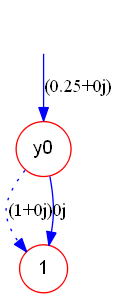

In [36]:
path='Benchmarks2/'

num=5

file_name='DQC_qft_'+str(num)+'.qasm'
file_name2='DQC_qft_'+str(num)+'_2.qasm'

cir1= QuantumCircuit.from_qasm_file(path+file_name)
cir2= QuantumCircuit.from_qasm_file(path+file_name2)

index_set=[]
for k in range(len(cir1._qubits)-1):
    index_set.append('x'+str(k))
    index_set.append('y'+str(k))

v=np.array([1,0])
input_state1=dict()
input_state2=dict()
for k in range(num):
    input_state1[k]=v
    input_state2[k]=v  
    
t_start=time.time()
tdd1,tdd2,max_nodes_num,res,time_dd = m_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
t_end=time.time()
print('Is equal:',res)
print('time:',t_end-t_start)
print('time dd:',time_dd)
print('tdd1_node_num_final:',tdd1.node_number())
print('tdd2_node_num_final:',tdd2.node_number())
print('node_num_max:',max_nodes_num)
TDD_show2(tdd2)
# cir1.draw()
# Equivalence_checking_of_DQC(cir1,cir2)

('y0', 1)
('y1', 1)
('y2', 1)
('y3', 1)
('y4', 1)
{-1: -1, 'y4': 0, 'y3': 1, 'y2': 2, 'y1': 3, 'y0': 4}
{-1: -1, 0: 'y4', 1: 'y3', 2: 'y2', 3: 'y1', 4: 'y0'}


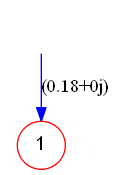

In [42]:
for k in tdd1.index_set:
        print(k)
print(tdd1.index_2_key)
print(tdd1.key_2_index)
print('=========================')
TDD_show2(tdd1)

In [38]:
# path='Benchmarks/'

# file_name='bitflip_code.qasm'
# file_name2='DQC_bitflip_code.qasm'
# index_set=['y3','y4','y5']
# v=np.array([1,0])
# input_state1={0:v,1:v,2:v,3:v,4:v,5:v}
# input_state2={0:v,1:v,2:v,3:v,4:v,5:v}

# file_name='phaseflip_code.qasm'
# file_name2='DQC_phaseflip_code.qasm'
# index_set=['y3','y4','y5']
# v=np.array([1,0])
# input_state1={0:v,1:v,2:v,3:v,4:v,5:v}
# input_state2={0:v,1:v,2:v,3:v,4:v,5:v}

# file_name='teleportation.qasm'
# file_name2='DQC_teleportation.qasm'
# index_set=['y0','y1']
# v=np.array([1,0])
# input_state1={1:v,2:v}
# input_state2={1:v,2:v}

# file_name='state_injection_S.qasm'
# file_name2='DQC_state_injection_S.qasm'
# index_set=['y1']
# v=np.array([1,1j])
# input_state1={1:v}
# input_state2={1:v}

# file_name='state_injection_T.qasm'
# file_name2='DQC_state_injection_T.qasm'
# index_set=['y1']
# v=np.array([1,complex(np.cos(np.pi/4),np.sin(np.pi/4))])
# input_state1={1:v}
# input_state2={1:v}


# cir1= QuantumCircuit.from_qasm_file(path+file_name)
# cir2= QuantumCircuit.from_qasm_file(path+file_name2)

# t_start=time.time()
# tdd1,tdd2,max_nodes_num,res,time_dd = q_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
# t_end=time.time()
# print('Is equal:',res)
# print('time:',t_end-t_start)
# print('time dd:', time_dd)
# print('tdd1_node_num_final:',tdd1.node_number())
# print('tdd2_node_num_final:',tdd2.node_number())
# print('node_num_max:',max_nodes_num)
# TDD_show2(tdd1)
# # cir1.draw()

In [39]:
# path='Benchmarks2/'

# excel_path = 'data/data2.xlsx'


# data=['Benchmarks','qubits','gate1','gate2','res','time','nodes1','node2','max_nodes']        
# data=np.array(data).reshape(1,len(data))
# df = pd.read_excel(excel_path, header=None)
# ds = pd.DataFrame(data)
# df = df.append(ds, ignore_index=True)
# df.to_excel(excel_path, index=False, header=False)        
        
# for q in range(12,13):

#     file_name='DQC_qft_'+str(q)+'.qasm'
#     file_name2='DQC_qft_'+str(q)+'_2.qasm'
#     cir1= QuantumCircuit.from_qasm_file(path+file_name)
#     cir2= QuantumCircuit.from_qasm_file(path+file_name2)
    
#     data = []
#     print('file_name:',file_name)
#     data.append(file_name)
#     data.append(q)
#     data.append(get_gate_num(cir1))
#     data.append(get_gate_num(cir2))
    
#     index_set=[]
#     for k in range(len(cir1._qubits)-1):
#         index_set.append('x'+str(k))
#         index_set.append('y'+str(k))

#     v=np.array([1,0])
#     input_state1=dict()
#     input_state2=dict()
#     for k in range(q):
#         input_state1[k]=v
#         input_state2[k]=v  
        
#     t_start=time.time()
#     tdd1,tdd2,max_nodes_num,res,time_dd = m_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
#     t_end=time.time()
#     print('Is equal:',res)
#     print('time:',t_end-t_start)
#     print('time dd:',time_dd)
#     print('tdd1_node_num_final:',tdd1.node_number())
#     print('tdd2_node_num_final:',tdd2.node_number())
#     print('node_num_max:',max_nodes_num)

#     data.append(res)
#     data.append(t_end-t_start)
#     data.append(time_dd)
#     data.append(tdd1.node_number())
#     data.append(tdd2.node_number())
#     data.append(max_nodes_num)


#     data=np.array(data).reshape(1,len(data))
#     df = pd.read_excel(excel_path, header=None)
#     ds = pd.DataFrame(data)
#     df = df.append(ds, ignore_index=True)
#     df.to_excel(excel_path, index=False, header=False)
#     print('---------------------')

In [40]:
path='Benchmarks2/'

excel_path = 'data/data2.xlsx'


# data=['Benchmarks','qubits','gate1','gate2','res','time','nodes1','node2','max_nodes']        
# data=np.array(data).reshape(1,len(data))
# df = pd.read_excel(excel_path, header=None)
# ds = pd.DataFrame(data)
# df = df.append(ds, ignore_index=True)
# df.to_excel(excel_path, index=False, header=False)        
        

file_name='DQC_bitflip_code.qasm'
file_name2='DQC_bitflip_code_2.qasm'
index_set=['y3','y4','y5']
v=np.array([1,0])
input_state1={0:v,1:v,2:v,3:v,4:v,5:v}
input_state2={0:v,1:v,2:v,3:v,4:v,5:v}

file_name='DQC_phaseflip_code.qasm'
file_name2='DQC_phaseflip_code_2.qasm'
index_set=['y3','y4','y5']
v=np.array([1,0])
input_state1={0:v,1:v,2:v,3:v,4:v,5:v}
input_state2={0:v,1:v,2:v,3:v,4:v,5:v}

# file_name='DQC_teleportation.qasm'
# file_name2='DQC_teleportation_2.qasm'
# index_set=['y0','y1']
# v=np.array([1,0])
# input_state1={1:v,2:v}
# input_state2={1:v,2:v}

# file_name='DQC_state_injection_S.qasm'
# file_name2='DQC_state_injection_S_2.qasm'
# index_set=['y1']
# v=np.array([1,1j])
# input_state1={1:v}
# input_state2={1:v}

# file_name='DQC_state_injection_T.qasm'
# file_name2='DQC_state_injection_T_2.qasm'
# index_set=['y1']
# v=np.array([1,complex(np.cos(np.pi/4),np.sin(np.pi/4))])
# input_state1={1:v}
# input_state2={1:v}

# data = []
# print('file_name:',file_name)
# data.append(file_name)
# cir1= QuantumCircuit.from_qasm_file(path+file_name)
# cir2= QuantumCircuit.from_qasm_file(path+file_name2)

# data.append(len(cir1._qubits))
# data.append(get_gate_num(cir1))
# data.append(get_gate_num(cir2))

# t_start=time.time()
# tdd1,tdd2,max_nodes_num,res,time_dd = q_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
# t_end=time.time()
# print('Is equal:',res)
# print('time:',t_end-t_start)
# print('time dd:', time_dd)
# print('tdd1_node_num_final:',tdd1.node_number())
# print('tdd2_node_num_final:',tdd2.node_number())
# print('node_num_max:',max_nodes_num)


# data.append(res)
# data.append(t_end-t_start)
# data.append(time_dd)
# data.append(tdd1.node_number())
# data.append(tdd2.node_number())
# data.append(max_nodes_num)


# data=np.array(data).reshape(1,len(data))
# df = pd.read_excel(excel_path, header=None)
# ds = pd.DataFrame(data)
# df = df.append(ds, ignore_index=True)
# df.to_excel(excel_path, index=False, header=False)
# print('---------------------')

In [41]:
# def gen_random_cir(cir):
#     case=np.random.randint(-1,2)
#     cir2=cir.copy()
# #     print(cir.data)
#     if case==0:
#         return cir2
#     if case==1:
#         q=np.random.randint(len(cir1._qubits))
#         gates=['x','y','z','h','s','t']
#         cir2.data=[]
#         g=np.random.randint(len(gates))
#         if g==0:
#             cir2.x(q)
#         if g==1:
#             cir2.x(q)
#         if g==2:
#             cir2.y(q)            
#         if g==3:
#             cir2.z(q)            
#         if g==4:
#             cir2.h(q)
#         if g==5:
#             cir2.s(q)
#         if g==6:
#             cir2.t(q)            
#         cir2.data+=cir.data
#         return cir2
#     if case==-1:
#         q=np.random.randint(len(cir1._qubits))
#         cir2.data=[]
#         cir2.data+=cir.data[1:]
#         return cir2
# path='Benchmarks/'
# num=6
# file_name='DQC_PE_'+str(num)+'.qasm'

# cir1= QuantumCircuit.from_qasm_file(path+file_name)
# cir2= gen_random_cir(cir1)
# print(len(cir1.data),len(cir2.data))

# index_set=[]
# for k in range(len(cir1._qubits)-1):
#     index_set.append('x'+str(k))
#     index_set.append('y'+str(k))

# # index_set.append('x'+str(num))
# v=np.array([1,0])
# input_state1=dict()
# input_state2=dict()
# for k in range(num):
#     input_state1[k]=v
#     input_state2[k]=v  
    
# t_start=time.time()
# tdd1,tdd2,max_nodes_num,res,time_dd = m_Equivalence(cir1,cir2,index_set,input_state1,input_state2)
# t_end=time.time()
# print('Is equal:',res)
# print('time:',t_end-t_start)
# print('time dd:',time_dd)
# print('tdd1_node_num_final:',tdd1.node_number())
# print('tdd2_node_num_final:',tdd2.node_number())
# print('node_num_max:',max_nodes_num)
# # TDD_show2(tdd1)
# # cir1.draw()